# Diffusion-deformation theories for hydrogels

Author: Jorge Urrea - 2024.01.17

## Introduction

We solve the transient nonlinear chemoelastic problem presented by Liu et al. (2016) using Fenics. This model describes the swelling kinetics of polymer gels. In this model both fields are fully coupled and it is assumed that the evolution is quasi-static, thus, the inertial effects are neglected. A staggered approach is adopted.

In [41]:
# This simulation takes around 20 mins
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
L = 0.01
# defining the top boundary of the plate
def top(x, on_boundary):
    return near(x[1], L) and on_boundary
# defining the bottom boundary of the plate 
def bottom(x, on_boundary):
    return near(x[1], 0) and on_boundary
# defining the left boundary of the plate
def left(x, on_boundary):
    return near(x[0], 0) and on_boundary
# defining the right boundary of the plate
def right(x, on_boundary):
    return near(x[0], L) and on_boundary

In [43]:
# Class representing the intial conditions
class InitialConditions(UserExpression):
    def eval(self, values, x):
        values[0] = 0.0                 # ux
        values[1] = 0.0                 # uy
        values[2] = -5.71 #-0.3124      # mu
    def value_shape(self):
        return (3,)

In [44]:
# Model parameters
# Elasticity parameters
# G0, χ = Constant(1.7e7), Constant(0.4)#Constant(0.2)
χ = Constant(0.2)
NΩ = Constant(1e-3)
Ω = Constant(1.7e-28)                          # the volume per solvent molecule
kBT = Constant(1.3806488e-23*298)              # T = 298 K
NkBT = Constant(1e25*1.3806488e-23*298)
D = Constant(0.2)#Constant(2e-4)#Constant(7.4e-11)                          # species diffusivity m^2 s^-1
mc = Constant(0.1)

In [45]:
# Kinematics
d = 2#u.geometric_dimension()
I = Identity(d)                         # Identity tensor

def F(u):
    return variable(I + grad(u)) 

# F = variable(I + grad(u))               # Deformation gradient
# C = F.T*F                             # Right Cauchy-Green tensor

# Left Cauchy-Green tensor
def B(u):
    return variable(F(u)*F(u).T)

# Invariants of deformation tensors
def Ic(u):
    return variable(tr(F(u).T*F(u)))
 
# Ic = tr(F(u).T*F(u))

def J(u):
    return variable(det(F(u)))

# J  = (det(F)) #1 + Ω*C

In [46]:
# Elasticity parameters
E, nu = 70e3, 0.3
mu, lmbda = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))
G0 = Constant(1e7)#Constant(40e3)#Constant(1e7/(1e25*1.3806488e-23*298))
print(E*nu/((1 + nu)*(1 - 2*nu)))
# Stored strain energy density (compressible neo-Hookean model + chem potential)
def psi(u,µ): 
    return variable((G0/2)*(Ic(u) - 3 - 2*ln(J(u)))
                     + (kBT/Ω)*((J(u) - 0.999)*ln(1 - 0.999/J(u)) + χ*(1 - 0.999/J(u)))
                     - kBT*(µ/Ω)*(J(u) -1)) # <== This is working

40384.61538461538


In [47]:
# first Kirchooff stress - PK1 
def p_mu(u,µ):
    # return variable(-µ + kBT/Ω*(ln(1 - 0.999/J(u)) + 1/J(u) + χ/(J(u)**2)))
    return variable(-µ/(Ω) + 1/(Ω)*(ln(1 - 0.999/J(u)) + 1/J(u) + χ/(J(u)**2)))
# p_mu = -µ/Ω + kBT/Ω*(ln(1 - 0.999/J(u)) + 1/J(u) + χ/(J(u)**2))

def sigma(u,µ):
    return variable(p_mu(u,µ)*I + inv(J(u))*(G0)*(B(u) - I))
# sigma = p_mu*I + inv(J(u))*G0*(B(u) - I)

def PK1(u,µ):
    return variable(J(u)*sigma(u,µ)*inv(F(u).T))
# PK1 = J(u)*sigma(u,µ)*inv(F(u).T)

In [48]:
# Main solver function
def solver_slab(N = 5, degree=1):

    mesh = UnitSquareMesh(N,N)
    
    # Scale the mesh to the desired domain size
    coordinates = mesh.coordinates()
    for coord in coordinates:
        coord *= L

    # Form compiler options
    parameters["form_compiler"]["optimize"]     = True
    parameters["form_compiler"]["cpp_optimize"] = True

    ### Field variable function spaces
    element_u = VectorElement('CG', mesh.ufl_cell(), degree + 1)    # displacement finite element
    element_mu = FiniteElement('CG', mesh.ufl_cell(), degree)       # chemical potential finite element
    W = FunctionSpace(mesh, MixedElement([element_u, element_mu]))

    # zero displacement boundary conditions on the symmetric part of the plate
    u_bc_bottom = DirichletBC(W.sub(0).sub(1), Constant(0.0), bottom) 
    u_bc_right = DirichletBC(W.sub(0).sub(0), Constant(0.0), right)
    u_bc_left = DirichletBC(W.sub(0).sub(0), Constant(0.0), left)

    # chemical potential on the outer boundaries
    mu_bc_top = DirichletBC(W.sub(1), Constant(0.0), top)
    # mu_bc_left = DirichletBC(V.sub(1), Constant(µ_swell), left)
    mu_bc_right = DirichletBC(W.sub(1), Constant(0.0), right)

    # bcs = [u_bc_bottom, u_bc_right, mu_bc_top, mu_bc_left]
    # bcs = [u_bc_bottom, u_bc_left, mu_bc_top, mu_bc_right]
    bcs = [u_bc_bottom, u_bc_left, u_bc_right, mu_bc_top]

    # Trial and test functions
    dU = TrialFunction(W)
    (du, dµ) = split(dU)

    V_ = TestFunction(W)
    (v, q) = split(V_)

    U = Function(W)
    (u, µ) = split(U)

    Uold = Function(W)
    (uold, µold) = split(Uold)

    # Create intial conditions and interpolate
    u_init = InitialConditions()
    Uold.interpolate(u_init)

    dt = Constant(0.)

    # Total potential energy
    Psi_n = psi(u,µ)*dx# - inner(T, u)*ds
    Pi_mech = derivative(Psi_n, u, v) 

    Jac_mech = derivative(Pi_mech, u, du) + derivative(Pi_mech, µ, dµ)

    D = 0.2e-4 # <= original value reported by Liu et al.
    # D = 0.15
    # D = 2.2e-2 # concentration dependent
    def mr(u):
        return variable(J(u)*(D)*inv(B(u))) # <== This one applies neglecting diff dependency of cR

    # Mass balance
    Pi_chem = (
                (inner(J(u)*grad(u - uold),inv(F(u).T))*q)*dx 
                + dt*inner(mr(u)*grad(µ),grad(q))*dx)
   
    Pi = Pi_mech + Pi_chem 

    Jac_chem = derivative(Pi_chem, u, du) + derivative(Pi_chem, µ, dµ) 

    Jac = Jac_mech + Jac_chem

    Nincr = 50
    t = np.linspace(0, 10, Nincr+1)
    Nx = 10
    x = np.linspace(0, L, Nx)
    µ_res = np.zeros((Nx, Nincr+1))

    lambda_res = np.zeros((Nx, Nincr+1))
    Jy_array = np.zeros((Nx, Nincr+1))
    sigma_x_array = np.zeros((Nx, Nincr+1))

    S = FunctionSpace(mesh, element_mu)

    for (i, dti) in enumerate(np.diff(t)):
        # print("Increment " + str(i+1))
        dt.assign(dti)

        begin("2D FEM sol")
        solve(Pi == 0, U, bcs, J = Jac, solver_parameters={"newton_solver":
                                            {"convergence_criterion": "incremental","maximum_iterations": 200}})
            #     {"relative_tolerance": 1e-6, "linear_solver": "gmres", "convergence_criterion": "incremental", "relaxation_parameter": 0.9}})
        Uold.assign(U)
        µ_res[:, i+1] = [U(L/2, xi)[2] for xi in x]

        (u, µ) = U.split()
        J_y = J(u)
        Jy_P1 = project(J_y, S)
        Jy_array[:, i+1] = [Jy_P1(L/2, xi) for xi in x] 
        
        sigma_x = p_mu(u,µ)
        sigma_x_P1 = project(sigma_x, S)
        sigma_x_array[:, i+1] = [sigma_x_P1(L/2, xi) for xi in x]
        end()
    
    # Compute magnitude of displacement
    u_magnitude = sqrt(dot(u, u))
    u_magnitude = project(u_magnitude, S)
    return mesh, u_magnitude, µ, µ_res, Jy_array, sigma_x_array  

In [49]:
def solver_1D_ref_sol(N = 200):

    # 1D NL PDE for lambda

    mesh_lambda = UnitIntervalMesh(N)
    
    # Scale the mesh to the desired domain size
    coordinates = mesh_lambda.coordinates()
    for coord in coordinates:
        coord *= L

    element_lambda = FiniteElement('CG', mesh_lambda.ufl_cell(), 2)
    P = FunctionSpace(mesh_lambda, element_lambda)

    dlambda = TrialFunction(P)
    p = TestFunction(P)

    lamda = Function(P)
    lamda_old = Function(P)

    # Create initial condition
    lambda_init = Expression("1.0", degree=1)
    lamda_old.interpolate(lambda_init)
    lamda.assign(lamda_old)

    # BCs
    lambda_right = 1.498
    lambda_bc_left = DirichletBC(P, Constant(0.0), left)
    labmda_bc_right = DirichletBC(P, Constant(lambda_right), right)

    bc_lambda = labmda_bc_right

    dt = Constant(0.)
    D1D = 2.0e-8
    def grad_lambda_X(lamda):
        return variable((1 + 1/(lamda**2))*grad(lamda)
                    + (1/NΩ)*(1/(lamda*(lamda - 0.99)) - 1/(lamda**2) - (2*χ)/(lamda**3))*grad(lamda))

    lambda_form = ((lamda - lamda_old)/dt*p #(1/NΩ)
                + dot((D1D)*(1/lamda)*grad_lambda_X(lamda), grad(p)))*dx
                
    Jac_lambda = derivative(lambda_form, lamda, dlambda)

    Nincr = 50
    t = np.linspace(0, 10, Nincr+1)
    # t = np.logspace(-2, 0, Nincr+1)
    Nx = 10
    x = np.linspace(0, L, Nx)

    lambda_res = np.zeros((Nx, Nincr+1))

    for (i, dti) in enumerate(np.diff(t)):
        print("Increment " + str(i+1))
        dt.assign(dti)

        begin("Computing 1D lambda sol")
        solve(lambda_form == 0, lamda, bc_lambda, J=Jac_lambda)#, 
            # solver_parameters={'linear_solver': 'gmres',
            #                  'preconditioner': 'ilu'})
        lamda_old.assign(lamda)
        lambda_res[:, i+1] = [lamda(xi) for xi in x]
        end()

    return lambda_res

In [50]:
# Function to verify model's solution using a single mesh density

import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from labellines import labelLine, labelLines

def run_solver_slab():
    # Run solver to compute and post-process solution
    N = 10
    mesh, u, µ_res, Jx_array, sigma_y_array = solver_slab(N)

    Nincr = 50
    t = np.linspace(0, 10, Nincr+1)
    Nx = 10
    x = np.linspace(0, L, Nx)

    fig, axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(10,8))
    axes = axes.flatten()

    ax = axes[0]
    ax.set_visible(False)

    # stretch
    # fig, ax = plt.subplots()
    ax = axes[1]

    nValues = np.arange(0,10)
    # setup the normalization and the colormap
    normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
    colormap = cm.viridis

    for n in nValues:
        # ax.plot(x, lambda_res[:, n+1], 'k.')
        ax.plot(x, Jx_array[:, n+1], color=colormap(normalize(n)), label="$t = {:.1f}$".format(t[n+1]))#, label=str(t[n]))


    labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=8)
    ax.set_xlabel("$Y$-coordinate along $X=0.5$", fontsize=14)
    ax.set_ylabel("stretch in the $Y$ direction $\lambda$", fontsize=14)
    ax.legend(["reference 1D sol.", "2D FEM approx."], fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)

    # chemical potential
    # fig, ax = plt.subplots()
    ax = axes[2]

    nValues = np.arange(0,10)
    # setup the normalization and the colormap
    normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
    colormap = cm.viridis

    # lambda_x = lambda_res[:, 1::Nincr//10]
    # # print(lambda_x - 1/lambda_x + np.log(1 - 1/lambda_x) + 1/lambda_x + 0.2/(lambda_x**2))
    # mu_x = 1.7e-28*1e7*(lambda_x - 1/lambda_x) + (1.3806488e-23*298)*(np.log(1 - 1/lambda_x) + 1/lambda_x + 0.2/(lambda_x**2))

    for n in nValues:
        # ax.plot(x, mu_x[:, n]/(1.3806488e-23*298), 'k.')
        ax.plot(x, µ_res[:, n+1], color=colormap(normalize(n)), label="$t = {:.1f}$".format(t[n+1]))#, label=str(t[n]))

    labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=8)
    ax.set_xlabel("$Y$-coordinate along $X=0.5$", fontsize=14)
    ax.set_ylabel("chemical potential \n in the $Y$ direction $\mu/k_B T$ [mol$^{-1}$]", fontsize=14)
    # ax.legend(["reference 1D sol.", "2D FEM approx."])
    ax.tick_params(axis='both', which='major', labelsize=14)

    ax = axes[3]

    nValues = np.arange(0,10)
    # setup the normalization and the colormap
    normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
    colormap = cm.viridis

    for n in nValues:
        ax.plot(x, (1.3806488e-23*298)*sigma_y_array[:, n+1], color=colormap(normalize(n)), label="$t = {:.1f}$".format(t[n+1]))#, label=str(t[n]))

    labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=8)
    ax.set_xlabel("$Y$-coordinate along $X=0.5$", fontsize=14)
    ax.set_ylabel("compressive stress \n in the $Y$ direction $\sigma_Y$ [Pa]", fontsize=14)
    # ax.legend(["reference 1D sol.", "2D FEM approx."])
    ax.tick_params(axis='both', which='major', labelsize=14)

    plt.show()

    # ax = axes[3]
    plt.figure(figsize=(5,5))
    # p = plot(u, mode="displacement")
    p = plot(u)
    plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
    plot(mesh, linewidth=0.7)
    cbar = plt.colorbar(p)#, shrink = 0.5)
    cbar.ax.tick_params(labelsize=14)
    plt.tick_params(axis='both', labelsize=14)
    plt.xlabel("$X$-coordinate", fontsize=14)
    plt.ylabel("$Y$-coordinate", fontsize=14)
    # plt.legend(["deformed gel"])
    plt.title("deformed gel", fontsize = 16)
    # plt.savefig('results/Liu/Fig_2DFEM_def_gel_equal_D.pdf')  
    # plt.savefig('results/Liu/Fig_2DFEM_def_gel.pdf')  
    plt.show()   

In [51]:
# Function to perform a mesh density convergence test

import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from labellines import labelLine, labelLines
import time

meshes = []
u_meshes = []
µ_meshes = []
µ_res_meshes = []
Jy_meshes = []
sigma_x_meshes = []

N_mesh = [25, 50, 100, 200]
# Iterate over mesh sizes
for N in N_mesh:
    start_time = time.time()
    print("Solving variational problem for mesh density = " + str(N))
    mesh, u, µ, µ_res, Jy_array, sigma_x_array = solver_slab(N)

    meshes.append(mesh)
    u_meshes.append(u)
    µ_meshes.append(µ)
    µ_res_meshes.append(µ_res)
    Jy_meshes.append(Jy_array)
    sigma_x_meshes.append(sigma_x_array)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"sim time = {elapsed_time:.2f}")

lambda_res = solver_1D_ref_sol()

Solving variational problem for mesh density = 25
2D FEM sol
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.342e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 5.691e+00 (tol = 1.000e-10) r (rel) = 4.241e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 1.234e+01 (tol = 1.000e-10) r (rel) = 9.196e+00 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 8.629e+00 (tol = 1.000e-10) r (rel) = 6.431e+00 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 1.767e+00 (tol = 1.000e-10) r (rel) = 1.317e+00 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 2.409e-01 (tol = 1.000e-10) r (rel) = 1.795e-01 (tol = 1.000e-09)
    Newton iteration 6: r (abs) = 1.019e-02 (tol = 1.000e-10) r (rel) = 7.590e-03 (tol = 1.000e-09)
    Newton iteration 7: r (abs) = 3.663e-05 (tol = 1.000e-10) r (rel) = 2.730e-05 (tol = 1.000e-09)
    Newton iteration 8: r (abs) = 9.516e-10 (tol = 1.000e-10) r (rel) = 7.092e-10 (tol = 1.000e-09

In [52]:
# Computational obtained convergence order
mesh = UnitSquareMesh(50,50)

# Scale the mesh to the desired domain size
coordinates = mesh.coordinates()
for coord in coordinates:
    coord *= L

element_mu = FiniteElement('CG', mesh.ufl_cell(), degree=1) 
S = FunctionSpace(mesh, element_mu)

# µ4 = project(µ_meshes[3], S)
# µ4 = sqrt(abs(assemble(µ4)))
µ4 = µ_meshes[3]
print(µ4(0,0))

# µ2 = project(µ_meshes[2], S)
# µ2 = sqrt(abs(assemble(µ2)))
µ2 = µ_meshes[2]
print(µ2(0,0))

# µ1 = project(µ_meshes[1], S)
# µ1 = sqrt(abs(assemble(µ1)))
µ1 = µ_meshes[1]
print(µ1(0,0))

# µ0 = project(µ_meshes[0], S)
# µ0 = sqrt(abs(assemble(µ0)))
µ0 = µ_meshes[0]
print(µ0(0,0))

conv_alpha_µ = 1/np.log10(2)*np.log10( np.abs( (µ1(0,0) - µ2(0,0))/(µ2(0,0) - µ4(0,0))) )
print("Convergence computed for mu at one point in the domain")
print(conv_alpha_µ)

# u4 = project(u_meshes[3], S)
u4 = u_meshes[3]
uh4 = u4(L,L)
print(uh4)

# u2 = project(u_meshes[2], S)
u2 = u_meshes[2]
uh2 = u2(L,L)
print(uh2)

# u1 = project(u_meshes[1], S)
u1 = u_meshes[1]
uh1 = u1(L,L)
print(uh1)

# u0 = project(u_meshes[0], S)
u0 = u_meshes[0]
uh0 = u0(L,L)
print(uh0)

conv_alpha_u = 1/np.log10(2)*np.log10( np.abs( (uh1 - uh2)/(uh2 - uh4)) )
print("Convergence computed for u at one point in the domain")
print(conv_alpha_u)

# error_u4 = project(u_meshes[3] - u_meshes[2], S)**2*dx
# E_u4 = sqrt(abs(assemble(error_u4)))
E_u4 = errornorm(u_meshes[3], u_meshes[2], norm_type='L2')
print(E_u4)

# error_u2 = project(u_meshes[3] - u_meshes[1], S)**2*dx
# E_u2 = sqrt(abs(assemble(error_u2)))
E_u2 = errornorm(u_meshes[3], u_meshes[1], norm_type='L2')
print(E_u2)

# error_u = project(u_meshes[3] - u_meshes[0], S)**2*dx
# E_u = sqrt(abs(assemble(error_u)))
E_u = errornorm(u_meshes[3], u_meshes[0], norm_type='L2')
print(E_u)

# E_test = errornorm(u_meshes[3], u_meshes[0], norm_type='L2')
# print(E_test)

conv_alpha_error_u = 1/np.log10(2)*np.log10( np.abs( (E_u - E_u2)/(E_u2 - E_u4)) )
print("Convergence computed for u from L2 norm")
print(conv_alpha_error_u)

# error_µ4 = project(µ_meshes[3] - µ_meshes[2], S)**2*dx
# E_µ4 = sqrt(abs(assemble(error_µ4)))
E_µ4 = errornorm(µ_meshes[3], µ_meshes[2], norm_type='L2')
print(E_µ4)

# error_µ2 = project(µ_meshes[3] - µ_meshes[1], S)**2*dx
# E_µ2 = sqrt(abs(assemble(error_µ2)))
E_µ2 = errornorm(µ_meshes[3], µ_meshes[1], norm_type='L2')
print(E_µ2)

# error_µ = project(µ_meshes[3] - µ_meshes[0], S)**2*dx
# E_µ = sqrt(abs(assemble(error_µ)))
E_µ = errornorm(µ_meshes[3], µ_meshes[0], norm_type='L2')
print(E_µ)

conv_alpha_error_µ = 1/np.log10(2)*np.log10( np.abs( (E_µ - E_µ2)/(E_µ2 - E_µ4)) )
print("Convergence computed for mu from L2 norm")
print(conv_alpha_error_µ)


-0.005751843187145905
-0.0057517487799963254
-0.005751266784987935
-0.0057489216284638935
Convergence computed for mu at one point in the domain
2.352050179715724
0.004954963114448227
0.0049549643814022675
0.004954969448018842
0.004954989698137777
Convergence computed for u at one point in the domain
1.9996584631402872
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
1.2507959225538951e-11
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
6.327066819792496e-11
2.622908507156157e-10
Convergence computed for u from L2 norm
1.9710737746817208
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
2.7158357869538553e-09
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
1.3737017886192412e-08
5.6950681558597045e-08
Convergence computed for mu from L

/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line0), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line1), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line2), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line3), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line4), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line5), but could not find a label for it.
  warnings.warn(
/usr/local/lib/p

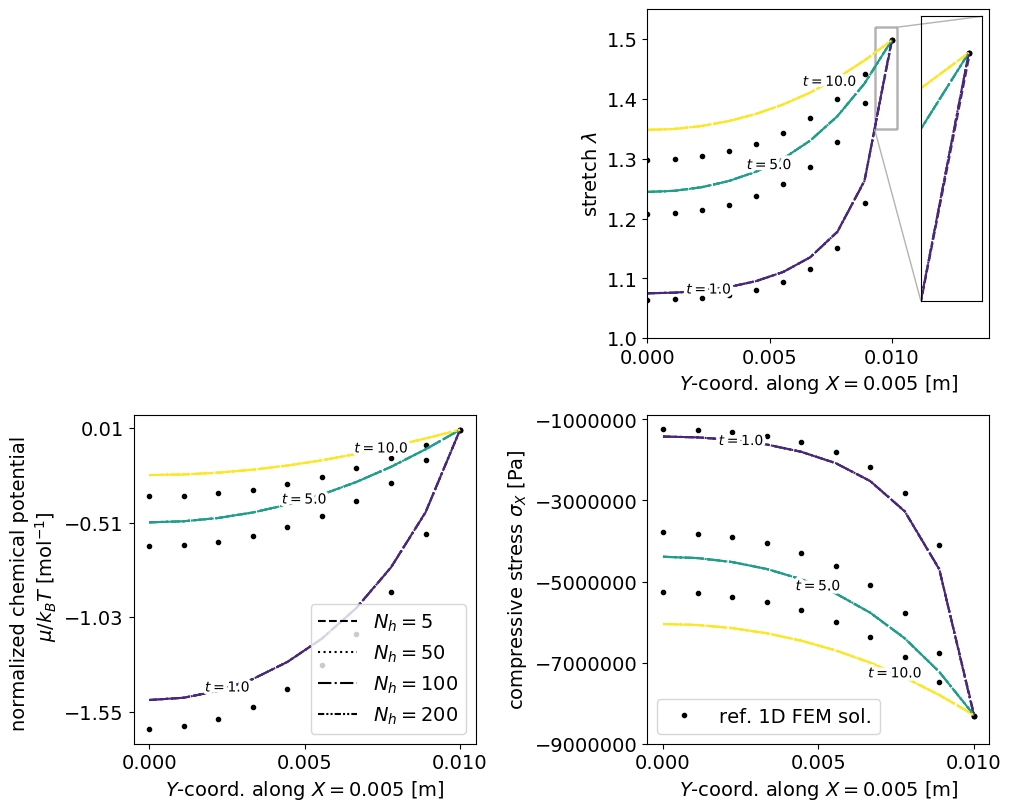

In [78]:
# print(µ_meshes[0])

Nincr = 10
t = np.linspace(0, 10, Nincr+1)
Nx = 10
x = np.linspace(0, L, Nx)

fig, axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(10,8))
axes = axes.flatten()

ax = axes[0]
ax.set_visible(False)

nMeshValues = np.arange(0,4)
nValues = np.arange(0,10)
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.viridis

# create a list of linestyles
linestyles = ['--', ':', '-.', (0, (3, 1, 1, 1, 1, 1))]
jj = 0

# stretch
# fig, ax = plt.subplots()
ax = axes[1]

for n in [1, 5, 10]:
    ax.plot(x, lambda_res[:, n], 'k.')

for m in nMeshValues:
    if m == 1:
        for n in [1, 5, 10]:
            # ax.plot(x, lambda_res[:, n], 'k.')
            ax.plot(x, Jy_meshes[m][:, n], linestyle=linestyles[jj], color=colormap(normalize(n)), label="$t = {:.1f}$".format(t[n]))#, label=str(t[n]))
    else:
        for n in [1, 5, 10]:
            # ax.plot(x, lambda_res[:, n], 'k.')
            ax.plot(x, Jy_meshes[m][:, n], linestyle=linestyles[jj], color=colormap(normalize(n)))#, label=str(t[n]))

    jj += 1

labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=10)
ax.set_xlabel("$Y$-coord. along $X=0.005$ [m]", fontsize=14)
ax.set_ylabel("stretch $\lambda$", fontsize=14)
# ax.legend(["ref. 1D FEM sol."], fontsize=14, loc='lower right')
# ax.legend(["N = 5", "N = 10", "N = 50"])
ax.tick_params(axis='both', which='major', labelsize=14)

ax.set_xlim(0.0, 0.014)
ax.set_ylim(1.0, 1.55)

x_ticks = np.linspace(0, 0.01, 3)  # 5 ticks from 0 to 0.01
y_ticks_lambda = np.linspace(1.0, 1.55, 3)  # Example for the lambda_res subplot
ax.set_xticks(x_ticks)
# ax.set_yticks(y_ticks_lambda)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

# Create a zoomed-in view and display it in a new axis
zoom_ax = zoomed_inset_axes(ax, 2.8, loc='upper right')

for n in [1, 5, 10]:
    zoom_ax.plot(x, lambda_res[:, n], 'k.')

jj = 0
for m in nMeshValues:
    if m == 1:
        for n in [1, 5, 10]:
            zoom_ax.plot(x, Jy_meshes[m][:, n], linestyle=linestyles[jj], color=colormap(normalize(n)), label="$t = {:.1f}$".format(t[n]))
    else:
        for n in [1, 5, 10]:
            zoom_ax.plot(x, Jy_meshes[m][:, n], linestyle=linestyles[jj], color=colormap(normalize(n)))

    jj += 1

# Adjust the x-limits for the zoomed region
zoom_ax.set_xlim(0.0093, 0.0102)
zoom_ax.set_ylim(1.35, 1.52)

# Remove axis labels
zoom_ax.set_xticks([])
zoom_ax.set_yticks([])

# Adjust the rectangle's x-coordinates and width
rect = plt.Rectangle((0.0093, 1.35), 0.0102-0.0093, 1.52-1.35, linewidth=1, edgecolor='k', facecolor='none')
ax.add_patch(rect)

# Mark the zoomed region in the original image
mark_inset(ax, zoom_ax, loc1=1, loc2=3, fc="none", ec="0.7")

ax = axes[2]
jj = 0

lambda_y = lambda_res[:, 1::Nincr//10]
mu_y = 1.7e-28*1e7*(lambda_y - 1/lambda_y) + (1.3806488e-23*298)*(np.log(1 - 1/lambda_y) + 1/lambda_y + 0.2/(lambda_y**2))

for n in [1, 5, 10]:
    ax.plot(x, mu_y[:, n-1]/(1.3806488e-23*298), 'k.')

# ax.plot(µ_meshes[0][:, 1:])
for m in nMeshValues:
    if m == 1:
        for n in [1, 5, 10]:
            # ax.plot(x, mu_x[:, n]/(1.3806488e-23*298), 'k.')
            ax.plot(x, µ_res_meshes[m][:, n], linestyle=linestyles[jj], color=colormap(normalize(n)), label="$t = {:.1f}$".format(t[n]))#, label=str(t[n]))
    else:
        for n in [1, 5, 10]:
            # ax.plot(x, mu_x[:, n]/(1.3806488e-23*298), 'k.')
            ax.plot(x, µ_res_meshes[m][:, n], linestyle=linestyles[jj], color=colormap(normalize(n)))#, label=str(t[n]))

    jj += 1

labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=10)
ax.set_xlabel("$Y$-coord. along $X=0.005$ [m]", fontsize=14)
ax.set_ylabel("normalized chemical potential \n $\mu/k_B T$ [mol$^{-1}$]", fontsize=14)
# ax.legend(["ref. 1D FEM sol."], fontsize=14, loc='upper left')
ax.tick_params(axis='both', which='major', labelsize=14)

x_ticks = np.linspace(0, 0.01, 3)  # 5 ticks from 0 to 0.01
y_ticks_mu = np.linspace(0.01, -1.55, 4)  # Example for the lambda_res subplot
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks_mu)

# create a list of labels
labels = ['$N_{h} = 5$', '$N_{h} = 50$', '$N_{h} = 100$', '$N_{h} = 200$']

# create custom legend handles and labels
handles = []
new_labels = []
indices_to_show = [0, 3, 6, 9]  # show the first and third legend
ii = 0
for i in indices_to_show:
    line = plt.Line2D([], [], color='k', linestyle=linestyles[ii], label=labels[ii])
    handles.append(line)
    new_labels.append(labels[ii])
    ii += 1

# create the legend with the custom handles and labels
ax.legend(handles=handles, labels=new_labels, fontsize=14, loc='lower right')

ax = axes[3]
jj = 0

sigma_x = -mu_y/1.7e-28 + (1.3806488e-23*298/1.7e-28)*(np.log(1 - 1/lambda_y) + 1/lambda_y + 0.2/(lambda_y**2)) 

for n in [1, 5, 10]:
    ax.plot(x, sigma_x[:, n-1], 'k.')

# ax.plot(µ_meshes[0][:, 1:])
for m in nMeshValues:
    if m == 1:
        for n in [1, 5, 10]:
            # ax.plot(x, sigma_y[:, n], 'k.')
            ax.plot(x, (1.3806488e-23*298)*sigma_x_meshes[m][:, n], linestyle=linestyles[jj], color=colormap(normalize(n)), label="$t = {:.1f}$".format(t[n]))#, label=str(t[n]))
    else:
        for n in [1, 5, 10]:
            # ax.plot(x, sigma_y[:, n], 'k.')
            ax.plot(x, (1.3806488e-23*298)*sigma_x_meshes[m][:, n], linestyle=linestyles[jj], color=colormap(normalize(n)))#, label=str(t[n]))

    jj += 1

labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=10)
ax.set_xlabel("$Y$-coord. along $X=0.005$ [m]", fontsize=14)
ax.set_ylabel("compressive stress $\sigma_X$ [Pa]", fontsize=14) 
ax.legend(["ref. 1D FEM sol."], fontsize=14, loc='lower left')
ax.tick_params(axis='both', which='major', labelsize=14)

x_ticks = np.linspace(0, 0.01, 3)  # 5 ticks from 0 to 0.01
y_ticks_stress = np.linspace(-9.0e6, -1.0e6, 5)  # Example for the lambda_res subplot
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks_stress)

# plt.savefig('results/Liu/Fig_refsol_2DFEM_mesh_converg_x001.pdf')

(1.2, 1.55)

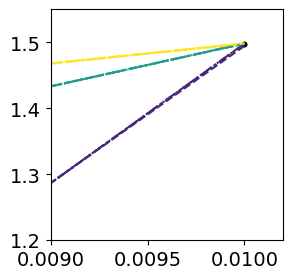

In [54]:
# stretch zoom
fig, ax = plt.subplots(figsize=(3,3))
# ax = axes[1]

for n in [1, 5, 10]:
    ax.plot(x, lambda_res[:, n], 'k.')

jj = 0
for m in nMeshValues:
    for n in [1, 5, 10]:
        ax.plot(x, Jy_meshes[m][:, n], linestyle=linestyles[jj], color=colormap(normalize(n)), label="$t = {:.1f}$".format(t[n]))#, label=str(t[n]))

    jj += 1

ax.tick_params(axis='both', which='major', labelsize=14)

# create a list of labels
labels = ['$N_{h} = 5$', '$N_{h} = 50$', '$N_{h} = 100$', '$N_{h} = 200$']

# create custom legend handles and labels
handles = []
new_labels = []
indices_to_show = [0, 3, 6, 9]  # show the first and third legend
ii = 0
for i in indices_to_show:
    line = plt.Line2D([], [], color='k', linestyle=linestyles[ii], label=labels[ii])
    handles.append(line)
    new_labels.append(labels[ii])
    ii += 1

# create the legend with the custom handles and labels
# ax.legend(handles=handles, labels=new_labels, fontsize=14, loc='lower right')

plt.xlim((0.009, 0.0102))
plt.ylim((1.2, 1.55))
plt.show()